In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
time = np.arange(4*365 + 1, dtype="float32")
baseline = 10
series=trend(time, 0.1)
amplitude = 20 
slope = 0.09
noise_level = 5

In [5]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

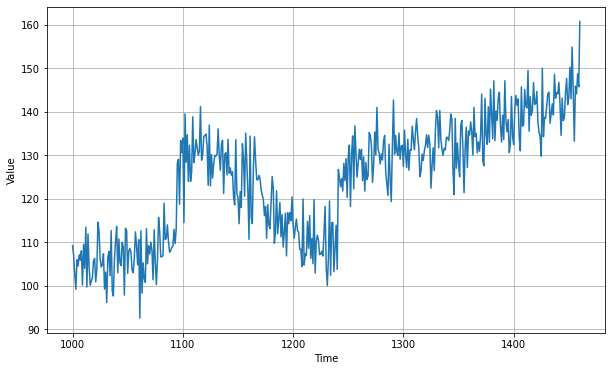

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [13]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [14]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

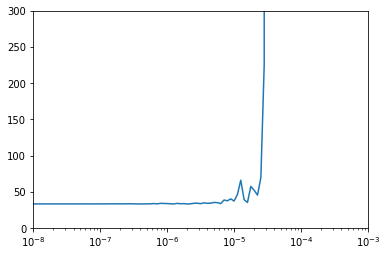

In [18]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [19]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

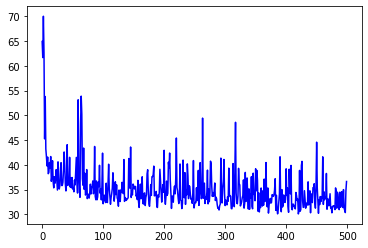

In [20]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[38.20122528076172, 38.46598815917969, 40.44813919067383, 39.321983337402344, 41.67339324951172, 36.664310455322266, 37.69215393066406, 40.82289123535156, 36.600643157958984, 35.335365295410156, 37.57609558105469, 36.280025482177734, 37.05338668823242, 39.02959060668945, 36.91059494018555, 34.89486312866211, 40.59754180908203, 36.19874572753906, 35.10139083862305, 35.81336975097656, 39.17041778564453, 40.42677688598633, 35.81216049194336, 35.81950759887695, 36.465431213378906, 38.99976348876953, 42.59873580932617, 39.85750961303711, 36.12173843383789, 34.71450424194336, 36.38709259033203, 44.06526184082031, 35.828086853027344, 36.85900115966797, 36.195552825927734, 41.516204833984375, 35.499324798583984, 37.36993408203125, 35.35980987548828, 37.43714141845703, 35.1298942565918, 35.37139892578125, 34.54228591918945, 36.904239654541016, 35.93130111694336, 38.69498062133789, 41.5045280456543, 36.99741744995117, 34.28842544555664, 53.15161895751953, 38.29008102416992, 35.23037338256836, 33

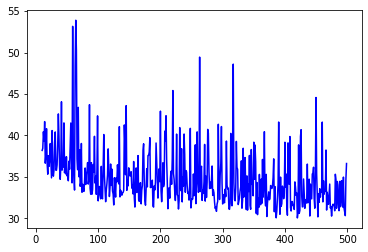

In [21]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

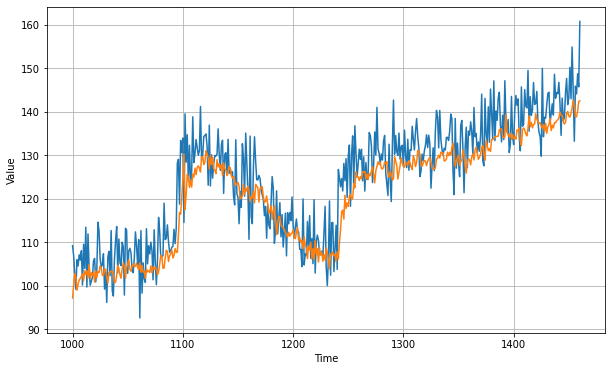

In [22]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.200684

In [24]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(30, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

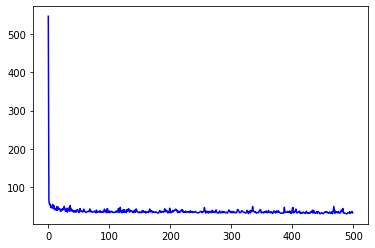

In [25]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[41.683040618896484, 44.26470947265625, 42.12747573852539, 39.463157653808594, 49.00350570678711, 39.366363525390625, 47.72683334350586, 43.00646209716797, 43.42247009277344, 43.06684112548828, 36.582733154296875, 41.48715591430664, 38.73814010620117, 43.23125457763672, 40.62913513183594, 45.5178337097168, 50.071598052978516, 42.767967224121094, 37.47065734863281, 36.537689208984375, 44.685447692871094, 34.60544204711914, 36.86586380004883, 45.47874450683594, 40.187923431396484, 37.31288146972656, 51.921810150146484, 37.922889709472656, 42.55522155761719, 37.7232551574707, 39.58209228515625, 35.21040725708008, 38.39751434326172, 35.21272277832031, 38.795230865478516, 34.44880294799805, 35.08445739746094, 40.34497833251953, 41.666019439697266, 37.18461990356445, 33.985137939453125, 34.29081344604492, 44.10346603393555, 38.28841781616211, 37.18781280517578, 37.28412628173828, 34.742897033691406, 36.148128509521484, 42.39823913574219, 36.80661392211914, 36.90289306640625, 34.1299629211425

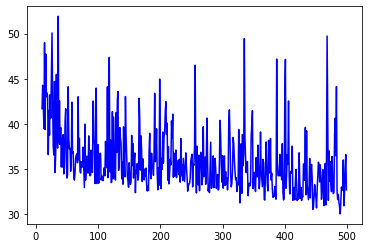

In [26]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

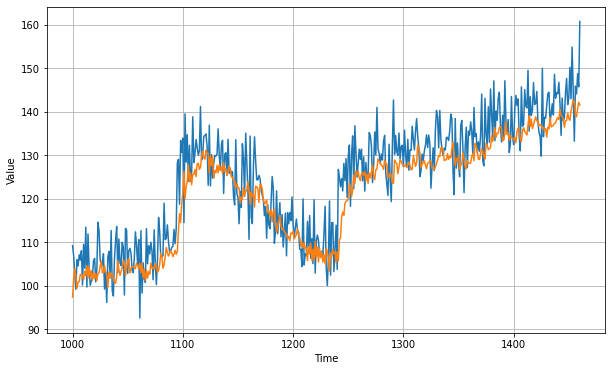

In [27]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2054124